In [1]:
"""
Watermark:
© Clarity Kummer 2024
"""

'\nWatermark:\n© Clarity Kummer 2024\n'

In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     GridSearchCV, RandomizedSearchCV)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree # for tree.plot_tree()
from sklearn.tree import export_text # for export_text()

In [3]:
raw_df = pd.read_csv('stats.csv')

In [4]:
df = raw_df.copy()
df.drop('last_name, first_name',axis = 1,inplace=True)
df.drop('player_id',axis = 1,inplace=True)

In [5]:
#new dataset for classification
c_df = df.copy()

# Define the OPS ranges and corresponding classifications
ops_ranges = {
    1: (0.7000, float('inf')),
    0: (-float('inf'), 0.6999)
}

# Create an empty list to store the classifications
classifications = []

for ops_value in c_df['on_base_plus_slg']:
    for classification, (lower_bound, upper_bound) in ops_ranges.items():
        if lower_bound <= ops_value < upper_bound:
            classifications.append(classification)
            break
    else:
        # If the OPS value didn't fall within any range, append a default value
        classifications.append('Unknown')

# Add the classifications to your dataset as a new column
c_df['Classification'] = classifications



#double checking that there are no missing or duplicated values for saftey 

if c_df.isna().any().any():
    print("There are missing values in the classification dataframe c_df.")
else:
    print("There are no missing values in the classification dataframe c_df")

if c_df.duplicated().any().any():
    print("There are duplicated values in the classification dataframe c_df.")
else:
    print("There are no duplicated values in the classification dataframe c_df")

c_df.head(n=5)

There are no missing values in the classification dataframe c_df
There are no duplicated values in the classification dataframe c_df


,year,pa,hit,single,double,triple,home_run,k_percent,bb_percent,on_base_plus_slg,...,barrel_batted_rate,solidcontact_percent,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,groundballs_percent,flyballs_percent,Classification
0,2020,231,51,37,4,0,10,22.1,10.4,0.746,...,9.7,5.8,49.7,102.655113,96.026886,31.6,47.7,42.6,21.9,1
1,2020,214,56,34,6,0,16,27.1,11.7,0.992,...,15.0,3.9,47.2,102.723680,95.933078,34.2,47.6,47.2,21.3,1
2,2020,218,61,45,10,1,5,20.6,6.0,0.772,...,5.0,6.3,36.3,100.556637,94.354591,21.1,46.6,51.2,18.8,1
3,2020,209,49,31,10,1,7,18.7,5.3,0.722,...,11.5,3.8,45.2,101.530260,95.520896,21.0,45.0,50.3,25.5,1
4,2020,213,46,26,9,3,8,18.8,8.9,0.752,...,6.5,8.4,38.3,97.982869,93.323023,20.5,46.1,45.5,26.6,1


In [6]:
#train test split datasets

c_train_df = c_df[(c_df['year'] == 2021) | (c_df['year'] == 2020)]
c_val_df = c_df[c_df.year==2022]
c_test_df = c_df[c_df.year==2023]


#### Base Full model 
#### StandardScaler
#### RandomOverSampleer

In [ ]:
features = ['k_percent','exit_velocity_avg','sweet_spot_percent', 'barrel_batted_rate','solidcontact_percent', 'hard_hit_percent', 
          'avg_best_speed','avg_hyper_speed',
          'whiff_percent', 'swing_percent',
          'groundballs_percent', 'flyballs_percent']

X_train = c_train_df[features]
y_train = c_train_df.Classification
print(f'The distribution of class obersvations in the training set are: {Counter(y_train)}.')


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 

In [8]:
ros = RandomOverSampler(random_state=0)

# Resample the dataset
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
Counter(y_train_resampled)

Counter({1: 235, 0: 235})

In [ ]:

clf = LogisticRegression()
clf.fit(X_train_resampled, y_train_resampled)
print(f'The accuracy on the scaled, resampled training data is: {clf.score(X_train_resampled,y_train_resampled):.3}.')

X_val = c_val_df[features]
X_val = scaler.transform(X_val)
y_true_val = c_val_df.Classification

#Make predictions on validation data
y_hat_val = clf.predict(X_val)

# Evaluate performance 
accuracy = accuracy_score(y_true_val, y_hat_val)
precision = precision_score(y_true_val, y_hat_val, average='weighted')
print(f'BASE FULL MODEL: \n training score accuracy: {clf.score(X_train_resampled,y_train_resampled):.3} \n validation accuracy: {accuracy:.3} \n validation precision: {precision:.3}.')


Grid Search

In [ ]:
parameters = [{'max_iter': [1000, 5000, 10000], 'C': [0.01, 1, 10, 1000], 'penalty': ['l2']}]
model = linear_model.LogisticRegression(multi_class='multinomial')
clf = GridSearchCV(model, parameters)
clf.fit(X_train_resampled, y_train_resampled)

print(f'clf.best_score_={clf.best_score_:.3}, ' +
      f'clf.best_params_={clf.best_params_}')

Evaluate Grid Search Model

In [ ]:
model = linear_model.LogisticRegression(multi_class = 'multinomial',C=1000,max_iter=1000,penalty='l2')
model.fit(X_train_resampled, y_train_resampled)
model.score(X_train_resampled, y_train_resampled)

print(f'The accuracy of the Grid Search Model on training data is: {model.score(X_train_resampled,y_train_resampled):.3}.')

#defining X_val and y_val 
X_val = c_val_df[features]
X_val = scaler.transform(X_val)
y_true_val = c_val_df.Classification

# Make predictions on validation data
y_hat_val = model.predict(X_val)

# Evaluate accuracy
accuracy = accuracy_score(y_true_val, y_hat_val)

# Evaluate precision
precision = precision_score(y_true_val, y_hat_val, average='weighted')
print(f'accuracy: {accuracy:.3}, precision: {precision:.3}.')


Feature Permutation

In [ ]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.inspection import permutation_importance
features = ['k_percent','exit_velocity_avg','sweet_spot_percent', 'barrel_batted_rate','solidcontact_percent', 'hard_hit_percent', 
          'avg_best_speed','avg_hyper_speed',
          'whiff_percent', 'swing_percent',
          'groundballs_percent', 'flyballs_percent']

model = linear_model.LogisticRegression(multi_class = 'multinomial',C=1000,max_iter=1000,penalty='l2')
model.fit(X_train_resampled, y_train_resampled)




X_val = c_val_df[features]
size = X_val.columns.size
columns = X_val.columns

X_val = scaler.transform(X_val)
y_true_val = c_val_df.Classification
r = permutation_importance(model, X_val, y_true_val, random_state = 0)
                      


# model.fit(X_train, y_train)
# X_val = c_val_df[features]
# y_true_val = c_val_df['Classification']
# pi = permutation_importance(model, X_val, y_true_val, random_state=0)

plt.figure(figsize=(8, 6))
plt.bar(x=range(size), height=r.importances_mean, tick_label=columns)
plt.title('Feature Importance for Logistic Regression (Classification)')
plt.xlabel('Feature Name')
plt.ylabel('Reduction in Accuracy on Shuffling Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Feature_importance_LogisticRegression_classification.png')
plt.show()




In [ ]:
features = ['k_percent', 'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed','avg_hyper_speed','flyballs_percent']

X_train = c_train_df[features]
y_train = c_train_df.Classification

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # do scaling

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# model = linear_model.LogisticRegression(multi_class = 'multinomial',C=1000,max_iter=1000,penalty='l2')
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

X_val = c_val_df[features]
y_true_val = c_val_df.Classification

X_val = scaler.transform(X_val)

y_hat_val = model.predict(X_val)


# Evaluate accuracy
accuracy = accuracy_score(y_true_val, y_hat_val)

# Evaluate precision
precision = precision_score(y_true_val, y_hat_val, average='weighted')

print(f'Reduced MODEL: \n training score accuracy: {model.score(X_train_resampled,y_train_resampled):.3} \n validation accuracy: {accuracy:.3} \n validation precision: {precision:.3}.')


Testing

In [ ]:
len(features)

In [ ]:
features = ['k_percent','exit_velocity_avg','sweet_spot_percent', 'barrel_batted_rate','solidcontact_percent', 'hard_hit_percent', 
          'avg_best_speed','avg_hyper_speed',
          'whiff_percent', 'swing_percent',
          'groundballs_percent', 'flyballs_percent']

X_train = c_train_df[features]
y_train = c_train_df.Classification

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # do scaling

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

model = linear_model.LogisticRegression(multi_class = 'multinomial',C=1000,max_iter=1000,penalty='l2')
model.fit(X_train_resampled, y_train_resampled)


X_test = c_test_df[features]
X_test_scaled = scaler.transform(X_test)
y_true_test = c_test_df['Classification']

y_hat_test = model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_true_test, y_hat_test)
test_precision = precision_score(y_true_test, y_hat_test, average='weighted')

print(f'Test accuracy: {test_accuracy:.3f}, Test precision: {test_precision:.3f}.')

cm = confusion_matrix(y_true_test, y_hat_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title('Confusion Matrix for 2023 Test Data')
plt.savefig('Confusion Matrix For 20203 Test Data.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc

# Classification report
print("Classification Report:")
print(classification_report(y_true_test, y_hat_test))

# ROC curve (if applicable)
if len(clf.classes_) == 2:  # Binary classification
    # Compute ROC curve and AUC for positive class
    fpr, tpr, _ = roc_curve(y_true_test, clf.predict_proba(X_test_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig('ROC Curve.png')
    plt.show()


In [31]:
features=['barrel_batted_rate','whiff_percent','swing_percent','flyballs_percent','exit_velocity_avg','avg_best_speed']

Accuracy on training data is model.score(X, y)=1.0.
Feature ranking:
1. barrel_batted_rate: 0.4152280768668515
2. whiff_percent: 0.1729543832570602
3. exit_velocity_avg: 0.1261043411752048
4. flyballs_percent: 0.11293481400440779
5. avg_best_speed: 0.09088688487751848
6. swing_percent: 0.08189149981895734


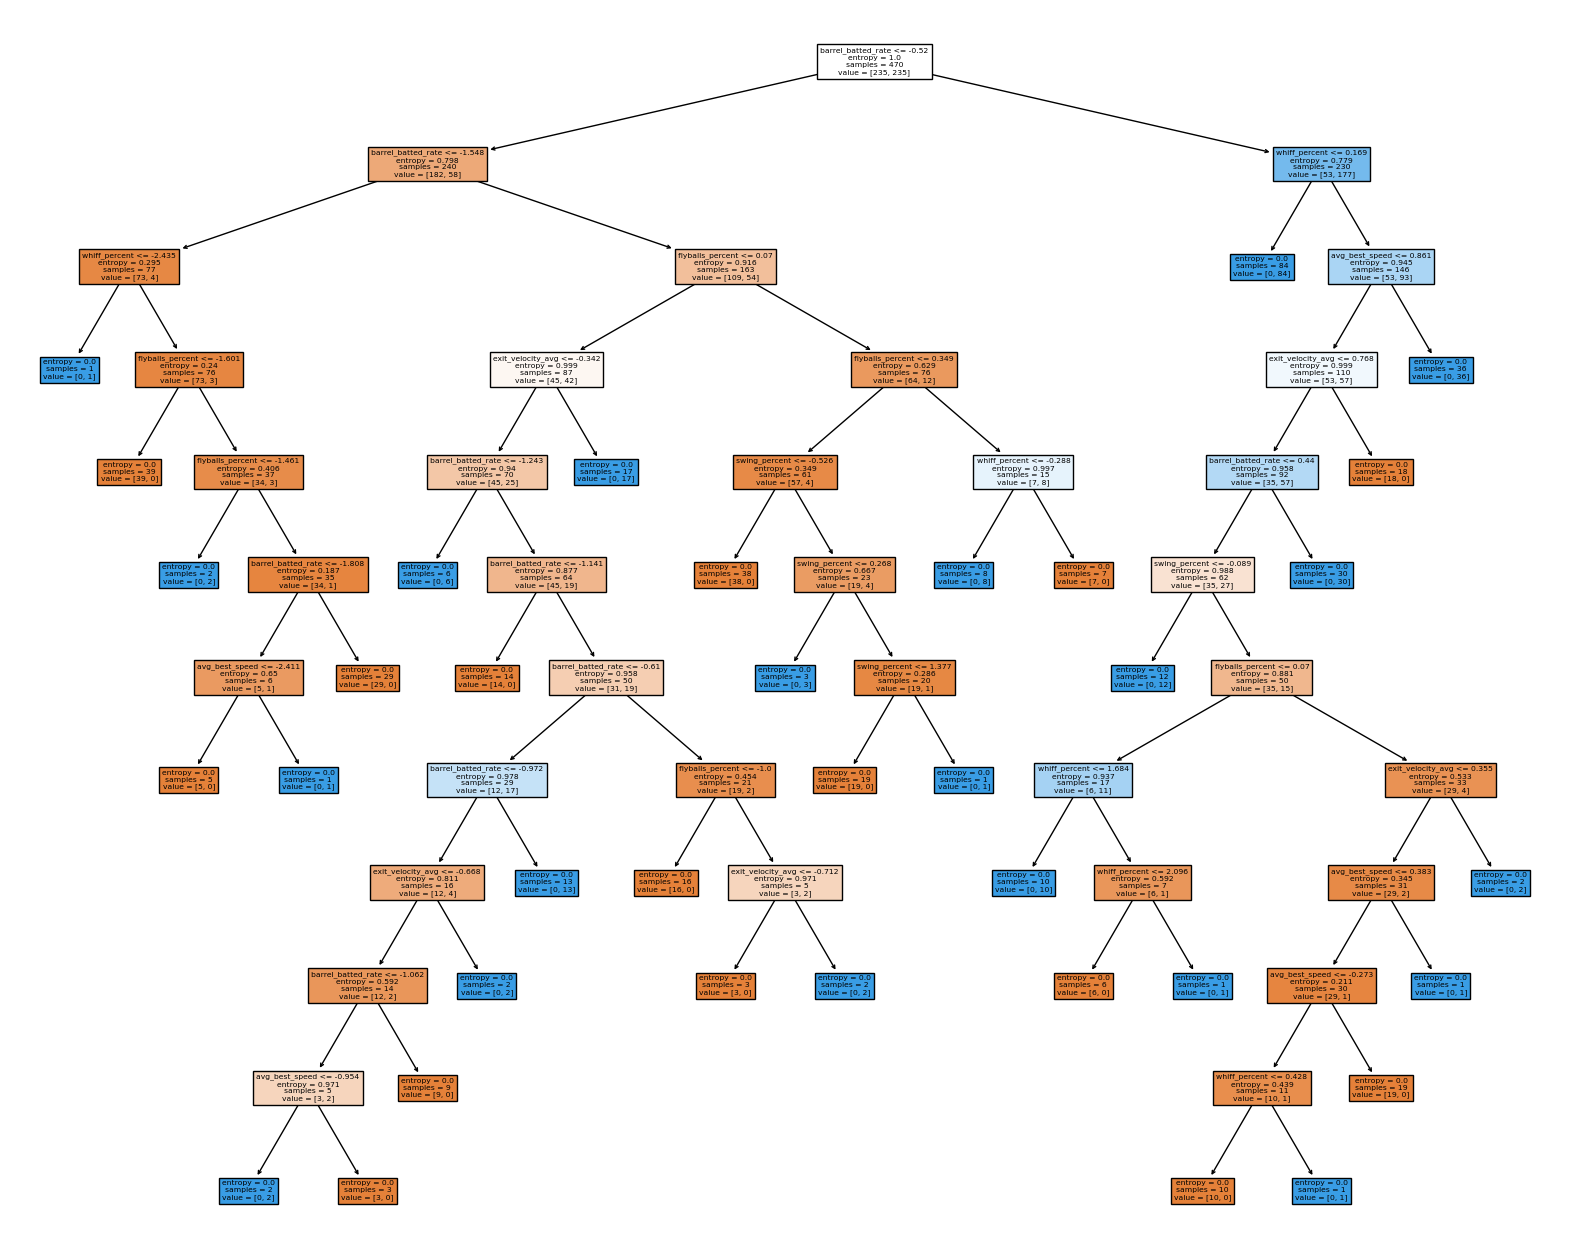

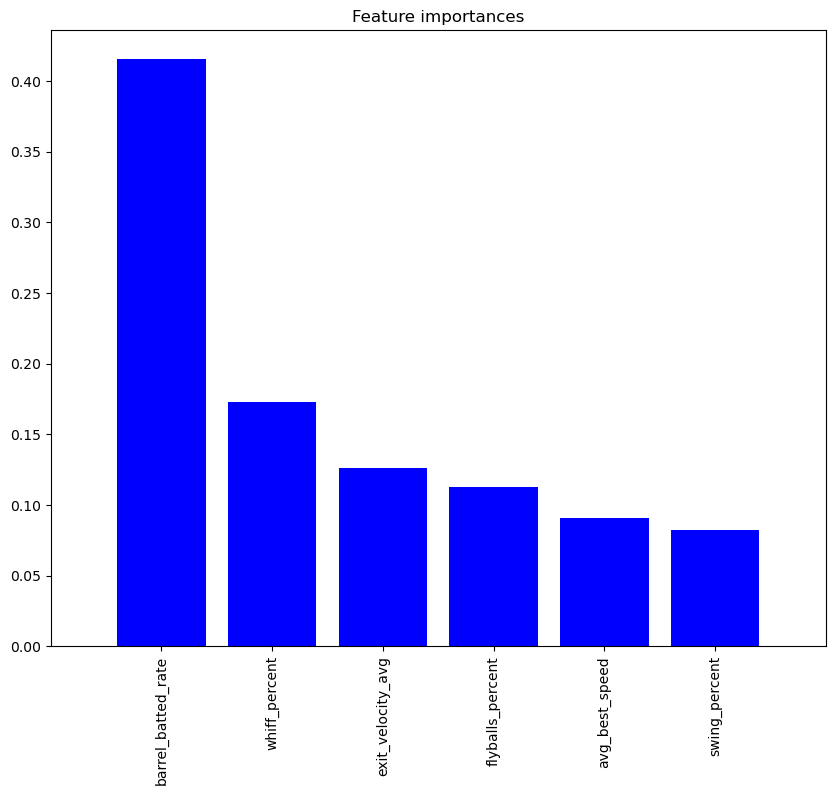

In [32]:
# features = ['k_percent','exit_velocity_avg','sweet_spot_percent', 'barrel_batted_rate','solidcontact_percent', 'hard_hit_percent', 
#           'avg_best_speed','avg_hyper_speed',
#           'whiff_percent', 'swing_percent',
#           'groundballs_percent', 'flyballs_percent']

X_train = c_train_df[features]
y_train = c_train_df.Classification

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # do scaling

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

model = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
model.fit(X_train_resampled, y_train_resampled)

plt.rcParams["figure.figsize"] = (20, 16) # (width, height) https://matplotlib.org/stable/api/figure_api.html
tree.plot_tree(model, feature_names=features, filled=True)
#print(export_text(model, feature_names=features))
print(f'Accuracy on training data is model.score(X, y)={model.score(X_train_resampled, y_train_resampled)}.')

importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(len(features)):
    print(f"{f + 1}. {features[indices[f]]}: {importances[indices[f]]}")

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices], color="b", align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation='vertical')
plt.xlim([-1, len(features)])
plt.show()

In [33]:
X_val = c_val_df[features]
X_val_scaled = scaler.transform(X_val)
y_true_val = c_val_df['Classification']
y_hat_val = model.predict(X_val_scaled)
print(f'Accuracy on val data is model.score(X_val_scaled, y_true_val)={model.score(X_val_scaled, y_true_val)}.')
#0.8153846153846154.

Accuracy on val data is model.score(X_val_scaled, y_true_val)=0.7846153846153846.


In [34]:
X_test = c_test_df[features]
X_test_scaled = scaler.transform(X_test)
y_true_test = c_test_df['Classification']

y_hat_test = model.predict(X_test_scaled)
print(f'Accuracy on test data is model.score(X, y)={model.score(X_test_scaled, y_true_test)}.')


Accuracy on test data is model.score(X, y)=0.8059701492537313.


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Assuming you have already imported necessary libraries and defined variables

# Define the parameter grid
param_grid = {
    'criterion': ['entropy'],
    'max_depth': [3, 5, 7, 9, None]
}

# Create the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=0)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Resample the training data
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

# Perform grid search
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
print(f'Accuracy on training data with best model is {best_model.score(X_train_resampled, y_train_resampled)}.')


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:
{'criterion': 'entropy', 'max_depth': None}
Accuracy on training data with best model is 1.0.


In [ ]:
row_data = raw_df.iloc[10:20,].copy()
row_data 
fun = pd.DataFrame(row_data)
fun
features = ['k_percent','exit_velocity_avg','sweet_spot_percent', 'barrel_batted_rate','solidcontact_percent', 'hard_hit_percent', 
          'avg_best_speed','avg_hyper_speed',
          'whiff_percent', 'swing_percent',
          'groundballs_percent', 'flyballs_percent']

x = scaler.transform(fun[features])
clf.predict(x)
print(f'predicted = {clf.predict(x)}.')
# print(f'\nactual =  \n{row_data.on_base_plus_slg}.')

# # fun = fun[features]
# # fun_numeric = fun.apply(pd.to_numeric)


# # X_fun = fun_numeric[xfeatures]

fun['on_base_plus_slg']


# # prediction = model.predict(X_fun)
# # predicted_obps = prediction[0] 


# # actual_obps = fun_numeric['on_base_plus_slg'].iloc[0]

# # print(f'The predicted obps is {predicted_obps:.3} and the actual obps is {actual_obps}.')